In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


In [2]:
#Import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import graphing utilities
import utilities.graphing_utils as utl

%matplotlib inline

#Import models
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import statsmodels as sm
import statsmodels.formula.api as smf
import joblib

In [3]:
#read in clean data file
clean_df = pd.read_csv('./datasets/clean.csv')

In [4]:
clean_df.head()

,Unnamed: 0,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,0,109,533352170,60,RL,0.0,13517,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
clean_df.isna().sum().sort_values(ascending = False)

pool_qc         2039
misc_feature    1983
alley           1907
fence           1648
fireplace_qu    1000
                ... 
id                 0
heating_qc         0
central_air        0
electrical         0
saleprice          0
Length: 82, dtype: int64

In [6]:
clean_df.columns

Index(['Unnamed: 0', 'id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage',
       'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_b

In [7]:
# Create a basline model
round(clean_df['saleprice'].median(),2)

162500.0

In [8]:

baseline_df = pd.DataFrame(clean_df['saleprice'])

In [9]:
baseline_df['predict_saleprice'] = round(clean_df['saleprice'].median(),2)
baseline_df.head()

,saleprice,predict_saleprice
0,130500,162500.0
1,220000,162500.0
2,109000,162500.0
3,174000,162500.0
4,138500,162500.0


In [10]:
#R2 score Errors for Baseline Model
r2_score(baseline_df['saleprice'], baseline_df['predict_saleprice'])

-0.05701863379506289

In [11]:
#Root Meal Squared Error for Baseline Model
mean_squared_error(baseline_df['saleprice'], baseline_df['predict_saleprice']) ** .5

81521.68767183187

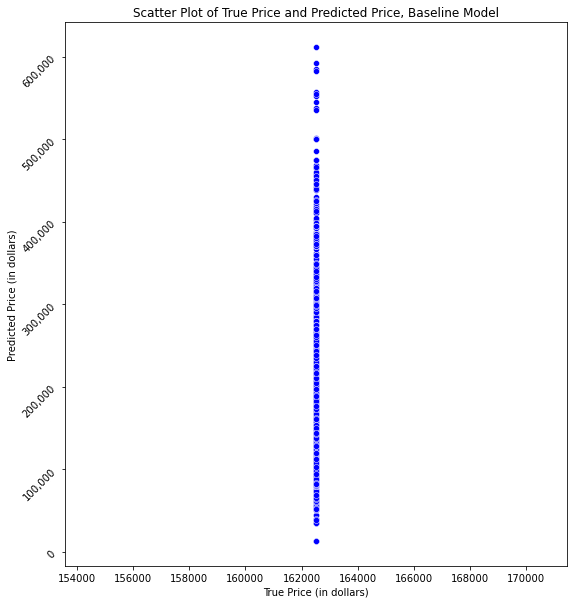

In [12]:
plt.figure(figsize = (9,10))
sns.scatterplot(baseline_df['predict_saleprice'], y = baseline_df['saleprice'], color = 'blue')
plt.plot(baseline_df['predict_saleprice'], baseline_df['predict_saleprice'], color = 'black')
plt.title('Scatter Plot of True Price and Predicted Price, Baseline Model')
plt.xlabel('True Price (in dollars)')
plt.ylabel('Predicted Price (in dollars)')
plt.yticks([0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000], 
                   ['0', '100,000', '200,000', '300,000', '400,000', '500,000', '600,000'],
                    rotation = 45);

In [13]:
#Pipeline that creates a DataFrame with the features to predict saleprice
#then point to modeling function and then to create the Kaggle Submission function
 
def pipeline(df):
    
    # Grab columns to include in my testing DataFrame
    features               = ['overall_qual', 'year_built', 'year_remod/add', 'mas_vnr_area', 'neighborhood',
                              'total_bsmt_sf', 'totrms_abvgrd', 'gr_liv_area', 'full_bath', 'garage_area', 'kitchen_qual',]
    X                      = df[features]

      

    # Fill missing values with zero to denote the house has no garage or kitchen 
    X.fillna(0,inplace=True)    
    
    # Group neigborhoods - above 75% 5(mean above 214_000); middle 50% 3(between 214_000 and 130_000), bottom 25% 1(below 130_000)
    X['neighborhood']      = X['neighborhood'].map({'NAmes'   : 3,
                                                    'CollgCr' : 3,
                                                    'OldTown' : 1,
                                                    'Edwards' : 1,
                                                    'Somerst' : 5,
                                                    'NridgHt' : 5,
                                                    'Gilbert' : 3,
                                                    'Sawyer'  : 3,
                                                    'SawyerW' : 3,
                                                    'NWAmes'  : 3,
                                                    'Mitchel' : 3,
                                                    'BrkSide' : 1,
                                                    'Crawfor' : 3,
                                                    'IDOTRR'  : 1,
                                                    'NoRidge' : 5,
                                                    'Timber'  : 5,
                                                    'StoneBr' : 5,
                                                    'SWISU'   : 3,
                                                    'ClearCr' : 5,
                                                    'MeadowV' : 1,
                                                    'Blmngtn' : 3,
                                                    'BrDale'  : 1,
                                                    'NPkVill' : 3,
                                                    'Veenker' : 5,
                                                    'Blueste' : 3,
                                                    'Greens'  : 3,
                                                    'GrnHill' : 5,
                                                    'Landmrk' : 3})
                                                                                         
    # extrapolate age from dataset creation minus year built 
    X['year_built']         = 2010 - X['year_built']
    X['year_remod/add']     = 2010 - X['year_remod/add']
    
    # map values for kitchen
    X['kitchen_qual']      = X['kitchen_qual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    
 
    # Feature interactions go here
#    X['overall_cond/overall_qual'] = X['overall_cond'] * X['overall_qual']

    # Columns to drop *** only run this once with inplace, right before I am ready to model....
#    X.drop(columns          = ['overall_cond', 'overall_qual'], inplace = True)

    return X
    
       

In [14]:
model = pipeline(clean_df)

In [15]:
model.shape

(2047, 11)

In [16]:
model.isna().sum()

overall_qual      0
year_built        0
year_remod/add    0
mas_vnr_area      0
neighborhood      0
total_bsmt_sf     0
totrms_abvgrd     0
gr_liv_area       0
full_bath         0
garage_area       0
kitchen_qual      0
dtype: int64

In [17]:
model.head()

,overall_qual,year_built,year_remod/add,mas_vnr_area,neighborhood,total_bsmt_sf,totrms_abvgrd,gr_liv_area,full_bath,garage_area,kitchen_qual
0,6,34,5,289.0,3,725.0,6,1479,2,475.0,4
1,7,14,13,132.0,3,913.0,8,2122,2,559.0,4
2,5,57,3,0.0,3,1057.0,5,1057,1,246.0,4
3,5,4,3,0.0,5,384.0,7,1444,2,400.0,3
4,6,110,17,0.0,3,676.0,6,1445,2,484.0,3


In [18]:
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall_qual    2047 non-null   int64  
 1   year_built      2047 non-null   int64  
 2   year_remod/add  2047 non-null   int64  
 3   mas_vnr_area    2047 non-null   float64
 4   neighborhood    2047 non-null   int64  
 5   total_bsmt_sf   2047 non-null   float64
 6   totrms_abvgrd   2047 non-null   int64  
 7   gr_liv_area     2047 non-null   int64  
 8   full_bath       2047 non-null   int64  
 9   garage_area     2047 non-null   float64
 10  kitchen_qual    2047 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 176.0 KB


In [19]:
def model_maker(X, y, model_type):
    '''This function is used to create a model and print out the R2 scores and cross val R2 scores on training and testing data.
    Keyword Arguments:
    X =  DataFrame of features
    y =  series of target
    model_type = string name of model type 'lr', 'ridge_cv','lasso'
    Returns model,'''

    # split the data into training and testing.
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 3)

    if model_type == 'lr':    
#         # split the data into training and testing.
#         X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 3)

        # Instantiate model
        lr = LinearRegression() 
        
        # Fit model
        lr.fit(X_train,y_train)    

        

        # Print Errors
        print(f'Model: {model_type}')
        print(f'Training Score: {lr.score(X_train, y_train)}')
        print(f'Testing Score: {lr.score(X_test, y_test)}')
        print(f'Cross Val Score - training: {cross_val_score(lr, X_train, y_train).mean()}')
        print(f'Cross Val Score - testing: {cross_val_score(lr, X_test, y_test).mean()}')
        print(f'Root Mean Square Error: train: {mean_squared_error(y_train, lr.predict(X_train)) ** .5}')
        print(f'Root Mean Square Error: test: {mean_squared_error(y_test, lr.predict(X_test)) ** .5}')

        plt.figure(figsize = (9,10))
        sns.scatterplot(lr.predict(X_test), y = y_test, color = 'blue')
        plt.plot(lr.predict(X_test), lr.predict(X_test), color = 'black')
        plt.title('Scatter Plot of True Price and Predicted Price, Linear Regression')
        plt.xlabel('True Price (in dollars)')
        plt.xticks([0, 100_000, 200_000, 300_000, 400_000], ['0', '100,000', '200,000', '300,000', '400,000'])
        plt.ylabel('Predicted Price (in dollars)')
        plt.yticks([0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000], 
                   ['0', '100,000', '200,000', '300,000', '400,000', '500,000', '600,000'],
                    rotation = 45);
        return lr
    else:
        # Instantiate Polynomial Features
        poly = PolynomialFeatures( interaction_only = False, include_bias = False)

        # fit and transform poly data with poly
        X_overfit = poly.fit_transform(X)
        
        # split the data into training and testing.
        X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_overfit, y, train_size = 0.7, random_state = 3) 

        # standardize the data
        sc = StandardScaler()
        X_train_poly_sc = sc.fit_transform(X_train_poly)
        X_test_poly_sc = sc.transform(X_test_poly)
        
        # Model based on the method
        if model_type == 'ols':
            ols = LinearRegression()
            ols.fit(X_train_poly_sc, y_train)
 
            #Print R2 scores
            print(f'Model: {model_type}')
            print(f'Training Score: {ols.score(X_train_poly_sc, y_train)}')
            print(f'Testing Score: {ols.score(X_test_poly_sc, y_test)}')
            print(f'Cross Val Score - training: {cross_val_score(ols, X_train_poly_sc, y_train).mean()}')
            print(f'Cross Val Score - testing: {cross_val_score(ols, X_test_poly_sc, y_test).mean()}')

            return ols


        if model_type == 'ridge_cv':
            #create alphas between 10^0, 10^5
            r_alphas = np.logspace(0, 5, 100)
            
            # Cross_validate over the list of ridge alphas
            ridge_cv = RidgeCV(alphas = r_alphas, scoring = 'r2', cv = 5)
            
            # fit the model using the best ridge alphas
            ridge_cv.fit(X_train_poly_sc, y_train)

            #Calculate Predictions
            preds = ridge_cv.predict(X_test_poly_sc)
            
            #Print R2 scores
            print(f'Model: {model_type}')
            print(f'Training Score: {ridge_cv.score(X_train_poly_sc, y_train)}')
            print(f'Testing Score: {ridge_cv.score(X_test_poly_sc, y_test)}')
            print(f'Cross Val Score - training: {cross_val_score(ridge_cv, X_train_poly_sc, y_train).mean()}')
            print(f'Cross Val Score - testing: {cross_val_score(ridge_cv, X_test_poly_sc, y_test).mean()}')
            print(f'Root Mean Square Error: train: {mean_squared_error(y_train, ridge_cv.predict(X_train_poly_sc)) ** .5}')
            print(f'Root Mean Square Error: test: {mean_squared_error(y_test, ridge_cv.predict(X_test_poly_sc)) ** .5}')

            plt.figure(figsize = (9,10))
            sns.scatterplot(preds, y = y_test, color = 'blue')
            plt.plot(preds, preds, color = 'black')
            plt.title('Scatter Plot of True Price and Predicted Price, Linear Regression with Regularization')
            plt.xlabel('True Price (in dollars)')
            plt.ylabel('Predicted Price (in dollars)')
            plt.yticks([0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000], 
                      ['0', '100,000', '200,000', '300,000', '400,000', '500,000', '600,000'],
                      rotation = 45);
            
            return (ridge_cv, sc)
        
        elif model_type == 'lasso':
            # create a list of Lasso alphas to check
            l_alphas = np.logspace(-3, 0 , 100)
            
            # Cross-validate over the list of Lasso Alphas
            lasso_cv = LassoCV(alphas = l_alphas, cv = 5, max_iter = 100_000)
            
            # fit model using best ridge aplha!
            lasso_cv.fit(X_train_poly_sc, y_train)
            
            #Calculate Predictions
            preds = lasso_cv.predict(X_test_poly_sc)
            
            #Print R2 scores
            print(f'Model: {model_type}')
            print(f'Training Score: {lasso_cv.score(X_train_poly_sc, y_train)}')
            print(f'Testing Score: {lasso_cv.score(X_test_poly_sc, y_test)}')
#            commented these out because it takes a long time to run
#            print(f'Cross Val Score - training: {cross_val_score(lasso_cv, X_train_poly_sc, y_train).mean()}')
#            print(f'Cross Val Score - testing: {cross_val_score(lasso_cv, X_test_poly_sc, y_test).mean()}')
            print(f'Root Mean Square Error: train: {mean_squared_error(y_train, lasso_cv.predict(X_train_poly_sc)) ** .5}')
            print(f'Root Mean Square Error: test: {mean_squared_error(y_test, lasso_cv.predict(X_test_poly_sc)) ** .5}')

            plt.figure(figsize = (9,10))
            sns.scatterplot(preds, y = y_test, color = 'blue')
            plt.plot(preds, preds, color = 'black',)
            plt.title('Scatter Plot of True Price and Predicted Price, Linear Regression with Regularization')
            plt.xlabel('True Price (in dollars)')
            plt.ylabel('Predicted Price (in dollars)')
            plt.xticks([0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000], ['0', '100,000', '200,000', '300,000', '400,000',  '500,000', '600,000'])
            plt.yticks([0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000], 
                       ['0', '100,000', '200,000', '300,000', '400,000', '500,000', '600,000'],
                       rotation = 45);
            return (lasso_cv, sc, poly, preds)          

Model: lr
Training Score: 0.8454700564859379
Testing Score: 0.8642679757209912
Cross Val Score - training: 0.8414580150163022
Cross Val Score - testing: 0.8661809799898439
Root Mean Square Error: train: 30297.539163742156
Root Mean Square Error: test: 31016.293503503108


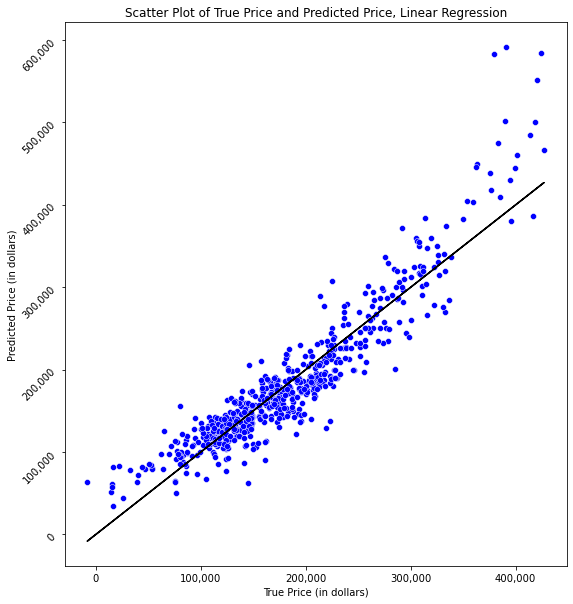

In [20]:
fit_model_lr = model_maker(model, clean_df['saleprice'],'lr')


Interpretation: 
* Since the R2 score for the testing data is greater than the training data, that means the model is underfit. To add further complexity, polynomial features along with Ridge and Lasso are used below.
* The r2 score also tells us that 90% of the variance is explained by the features.
* RMSE - means that the predicted sale price is off by around 30,000 dollars for both the training and testing data.
* The scatter plot of the true price and predicted price shows that the data is a little curved. Adding polynomial features can help straighten the line.


In [21]:
features = list(model)
features

['overall_qual',
 'year_built',
 'year_remod/add',
 'mas_vnr_area',
 'neighborhood',
 'total_bsmt_sf',
 'totrms_abvgrd',
 'gr_liv_area',
 'full_bath',
 'garage_area',
 'kitchen_qual']

In [22]:
coef_lr = pd.DataFrame(list(zip(features, fit_model_lr.coef_)), columns = ['features', 'coef'])

In [23]:
coef_lr.sort_values('coef')

,features,coef
8,full_bath,-9209.535909
6,totrms_abvgrd,-855.507708
2,year_remod/add,-231.255266
1,year_built,-53.213769
3,mas_vnr_area,32.277973
9,garage_area,33.260581
5,total_bsmt_sf,37.325644
7,gr_liv_area,58.446753
4,neighborhood,6219.516268
0,overall_qual,12466.549288


Interpretation:
* Most positive coefficients:
  * Kitchen_qual : When all else is held constant, 1 dollar spent in the kitchen will increase the value of the house by 18_850 dollars.
  * Overall_qual : When all else is held constant, 1 dollar spent on the overall quality will increase the value of the house by 12_500 dollars.
* Most negative coefficients:
  * Full_bath : When all else is held constant, for each additional full bath, the value of the house will decrease around 9_000 dollars.


In [24]:
fit_model_lr.intercept_

-97241.72383380783

Interpretation:
The starting sale price is around -97,241 dollars (which doesn't make sense)

Model: ridge_cv
Training Score: 0.8960759747157779
Testing Score: 0.9095207715948826
Cross Val Score - training: 0.8807804472649312
Cross Val Score - testing: 0.9135354425081734
Root Mean Square Error: train: 24846.144837288626
Root Mean Square Error: test: 25323.46785959504


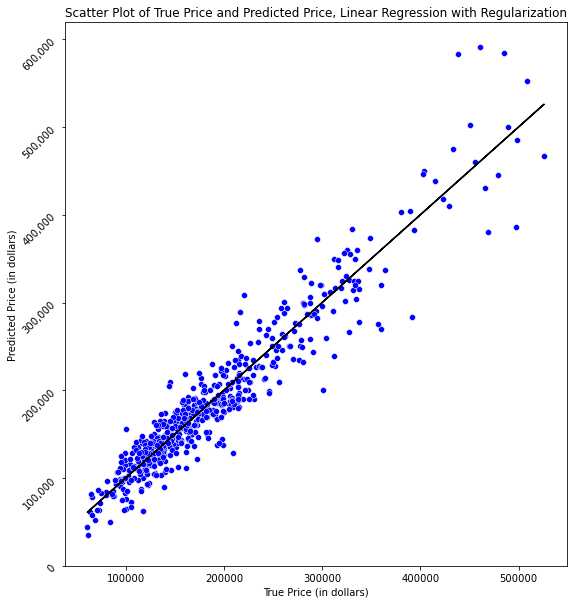

In [25]:
fit_model_ridge = model_maker(model, clean_df['saleprice'],'ridge_cv')

Interpretation:

Since the R2 score for the testing data is greater than the training data, that means the model is underfit. The ridge model is less underfit than the origin model. To add further complexity, polynomial features along with Lasso are used below. The r2 score also tells us that 90% of the variance is explained by the features.
RMSE - means that the predicted sale price is off by around 25,000 dollars for both the training and testing data.
The scatter plot of the true price and predicted price shows that the data is a little curved. Adding polynomial features can help straighten the line.

In [26]:
fit_model_ridge[0].intercept_

180425.62569832403

Interpretation:
The starting sale price is around 180,425 dollars.

Model: lasso
Training Score: 0.9035592094495561
Testing Score: 0.9061581985399926
Root Mean Square Error: train: 23934.888764813535
Root Mean Square Error: test: 25789.736374627915


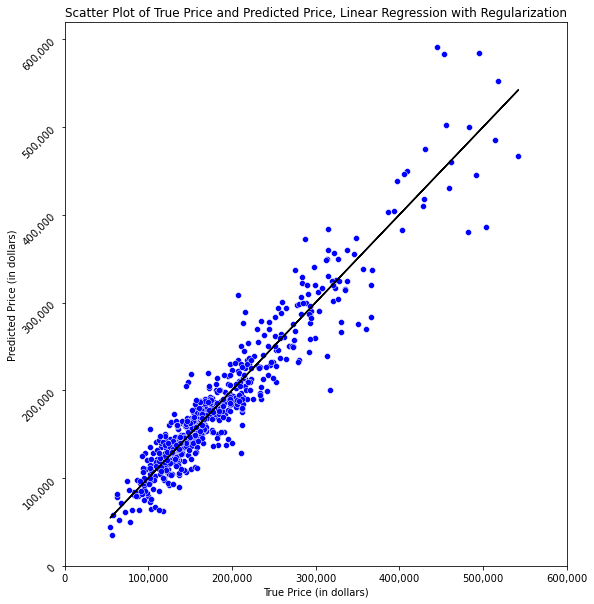

In [27]:
fit_model_lasso = model_maker(model, clean_df['saleprice'],'lasso')

Interpretation:

Since the R2 score for the testing data is greater by only .3%, the model seems to be hitting the sweet spot between underfit compared to overfit. To add further complexity, polynomial features along with Ridge and Lasso are used below.The r2 score also tells us that 90% of the variance is explained by the features.
RMSE - means that the predicted sale price is off by around 25,000 dollars for both the training and testing data.
The scatter plot of the true price and predicted price shows that the data is a little curved. Adding polynomial features seemed to help straighten the line.
However the predicted sale price still is off by a lot of money, plus or minus 25,000 dollars

In [28]:
fit_model_lasso[2].get_feature_names(model.columns)[:2]

['overall_qual', 'year_built']

In [29]:
coef_lasso = pd.DataFrame(list(zip(fit_model_lasso[2].get_feature_names(model.columns), fit_model_lasso[0].coef_)), columns = ['features', 'coef'])

In [30]:
# featuers that have the largest negative coefficents
coef_lasso.sort_values(by = 'coef' ).head()

,features,coef
63,totrms_abvgrd gr_liv_area,-69253.106896
10,kitchen_qual,-53464.715580
6,totrms_abvgrd,-22709.013735
1,year_built,-20313.754728
19,overall_qual full_bath,-19429.697878


In [31]:
# featuers that have the largest postive coefficents
coef_lasso.sort_values(by = 'coef' , ascending = False).head()

,features,coef
17,overall_qual totrms_abvgrd,32135.134578
62,totrms_abvgrd^2,28498.228757
73,full_bath kitchen_qual,25776.144081
16,overall_qual total_bsmt_sf,23635.934609
21,overall_qual kitchen_qual,21825.035407


In [32]:
# featuers that have the smallest impact
coef_lasso.sort_values(by = 'coef' )[35:45]

,features,coef
37,year_remod/add gr_liv_area,-888.850262
34,year_remod/add neighborhood,-503.410408
56,total_bsmt_sf^2,-390.252180
66,totrms_abvgrd kitchen_qual,-0.000000
69,gr_liv_area garage_area,423.535741
23,year_built year_remod/add,481.822849
55,neighborhood kitchen_qual,675.878703
39,year_remod/add garage_area,708.485341
41,mas_vnr_area^2,1160.017814
26,year_built total_bsmt_sf,1390.207275


Interpretation:
* Most positive coefficients:
  *  Interaction between overall quality and total rooms above ground
  *  Total rooms above ground (degree 2)
  *  Interaction between number of full baths and kitchen quality
  *  Interaction between overall quality and total basement square footage
  *  Interaction between overall kitchen quality and kitchen quality
* Most negative coefficients:
  *  Intereaction between total rooms above ground and above ground living area 
* No impact:
  * Interaction between total rooms above ground and kitchen qual has no impact on the model.


In [33]:
fit_model_lasso[0].intercept_

180425.62569832403

Interpretation:
The starting sale price is around 180,425 dollars

In [34]:
def test_my_model(submission_name, model, model_type, sc = '', poly = ''):
    '''Use this function to create a submission to post onto Kaggle
       Keyword Arguments:
       Submision_number : string; submision name
       model: model that was created in pipeline'''

    # read the testing data
    test_csv          = pd.read_csv('./datasets/test.csv')

    # convert testing data to snake case
    test_csv.columns  = [ utl.convert_to_snake_case(col) for col in test_csv.columns]

    # run the data through the pipeline so it is formated for the model
    test              = pipeline(test_csv)

    # create predictions on the test data
    if model_type == 'lasso':
        print('Yes')

        #apply polynomial features
        test_poly = poly.transform(test)
        
        #standardize the data
        test_sc = sc.transform(test_poly)
 
        submit = test_sc
    else:  
        submit = test
        
    saleprice         = model.predict(submit)

    # create data frame
    test['saleprice'] = saleprice
    testing           = test.join(test_csv['id'])

    #create csv file in submissions folder
    filename          = './submissions/' + submission_name
    testing[['id', 'saleprice']].to_csv(filename, index = False)
    
    print(list(zip(poly.get_feature_names(test.columns), model.coef_)))
    return  
    

In [35]:
#test_my_model('test.csv', fit_model_lr, 'lr')

In [36]:
#test_my_model('submit_5.csv', fit_model_lasso[0],'lasso',fit_model_lasso[1], fit_model_lasso[2])

In [37]:
#Save model
#joblib.dump(fit_model_lr, 'model_5_lr.sav')
#joblib.dump(fit_model_lasso, 'model_5_lasso.sav')

In [38]:
#save the features and salprice so visuals can be created

In [39]:
model = model.merge(clean_df['saleprice'], left_index= True, right_index=True)
model.head()

,overall_qual,year_built,year_remod/add,mas_vnr_area,neighborhood,total_bsmt_sf,totrms_abvgrd,gr_liv_area,full_bath,garage_area,kitchen_qual,saleprice
0,6,34,5,289.0,3,725.0,6,1479,2,475.0,4,130500
1,7,14,13,132.0,3,913.0,8,2122,2,559.0,4,220000
2,5,57,3,0.0,3,1057.0,5,1057,1,246.0,4,109000
3,5,4,3,0.0,5,384.0,7,1444,2,400.0,3,174000
4,6,110,17,0.0,3,676.0,6,1445,2,484.0,3,138500


In [40]:
model.to_csv('./datasets/model_df.csv')